In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
from torchviz import make_dot

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.probabilistic_scene_grammar_nodes import *
from scene_generation.models.probabilistic_scene_grammar_model import *

In [2]:
seed = 47
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
pyro.enable_validation(True)
pyro.clear_param_store()

/home/gizatt/projects/scene_generation/models/probabilistic_scene_grammar_nodes.py:192: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.production_dist.log_prob(torch.tensor(selected_rules)).sum()


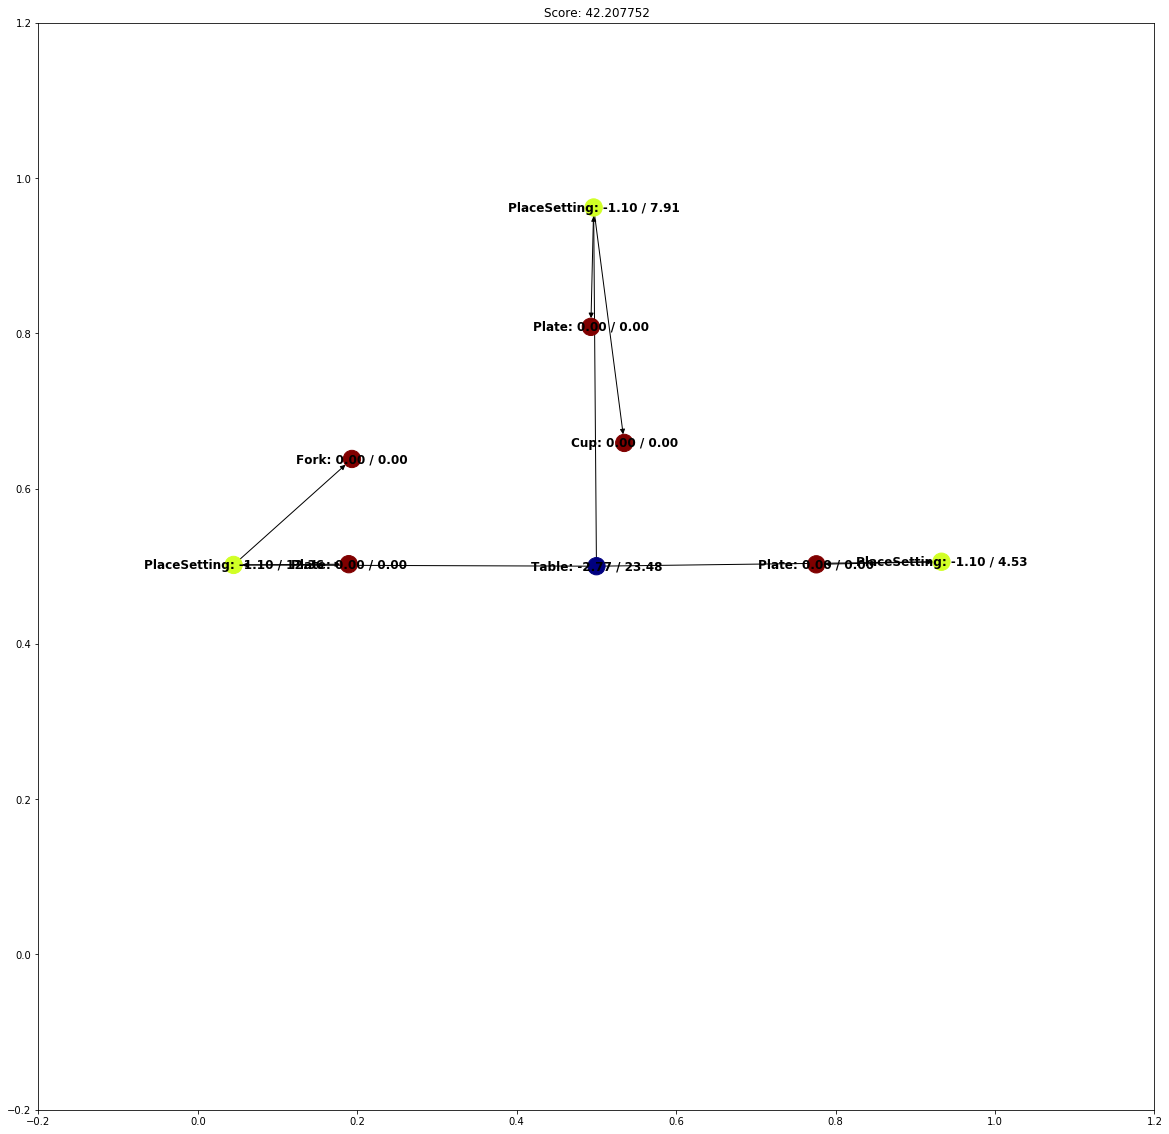

In [3]:
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
trace = poutine.trace(generate_unconditioned_parse_tree).get_trace()
parse_tree = trace.nodes["_RETURN"]["value"]        
score = trace.log_prob_sum()
draw_parse_tree(parse_tree, label_name=True, label_score=True)

In [4]:
# Clear gradients
for param_name in pyro.get_param_store():
    pyro.param(param_name).grad = None
# Calc gradients of score w.r.t. all params
trace = poutine.trace(rerun_conditioned_parse_tree).get_trace(
    parse_tree, score_terminal_products=True, score_nonterminal_products=True)
score = trace.log_prob_sum()
print("score: ", score)
score.backward(retain_graph=True)
def print_param_store(grads=False):
    for param_name in pyro.get_param_store().keys():
        val = pyro.param(param_name)#.tolist()
        grad = pyro.param(param_name).grad
        #if isinstance(val, float):
        #    val = [val]
        if grads:
            print(param_name, ": ", val.data, ", unconstrained grad: ", pyro.get_param_store()._params[param_name].grad)
        else:
            print(param_name, ": ", val.data)
print_param_store(grads=True)
fork_node = next(obj for obj in parse_tree.nodes if isinstance(obj, Fork))
#print(list(parse_tree.predecessors(fork_node))[0].offset_dist.scale)

score:  tensor(42.2077, grad_fn=<AddBackward0>)
table_place_setting_var :  tensor([0.0100, 0.0100, 0.1000]) , unconstrained grad:  tensor([-3.0000, -3.0000, -3.0000])
place_setting_left_fork_mean :  tensor([-0.1500,  0.1600,  0.0000]) , unconstrained grad:  tensor([ 7.6294e-06, -7.6294e-06,  0.0000e+00])
place_setting_cup_mean :  tensor([0.0000, 0.3100, 0.0000]) , unconstrained grad:  tensor([-9.5367e-07,  0.0000e+00,  0.0000e+00])
table_place_setting_mean :  tensor([0.0000, 0.0000, 1.5708]) , unconstrained grad:  tensor([-1.5259e-05, -3.8147e-06, -9.5367e-06])
place_setting_plate_var :  tensor([0.0100, 0.0100, 3.0000]) , unconstrained grad:  tensor([-3.0000, -3.0000, -3.0000])
table_radius :  tensor(0.4500) , unconstrained grad:  tensor(-6.8665e-06)
place_setting_plate_mean :  tensor([0.0000, 0.1600, 0.0000]) , unconstrained grad:  tensor([ 7.6294e-06, -1.3351e-05,  0.0000e+00])
table_independent_set_production_probs :  tensor([0.5000, 0.5000, 0.5000, 0.5000]) , unconstrained grad:  t

In [5]:
fork = next(obj for obj in parse_tree.nodes if isinstance(obj, Fork))
fork_prod = list(parse_tree.predecessors(fork))[0]
loc = pyro.param("place_setting_left_fork_mean") # fork_prod.offset_dist.mean
scale = pyro.param("place_setting_left_fork_var") # fork_prod.offset_dist.variance
loc.grad = None
scale.grad = None

local_score = fork_prod.score_products(list(parse_tree.predecessors(fork_prod))[0], [fork])
local_score.backward(retain_graph=True)
print(local_score)
print("Loc: ", loc, loc.grad)
print("Scale: ", scale, scale.grad)

tensor(8.3907, grad_fn=<SumBackward0>)
Loc:  tensor([-0.1500,  0.1600,  0.0000], requires_grad=True) tensor([ 7.6294e-06, -7.6294e-06,  0.0000e+00])
Scale:  tensor([0.0100, 0.0100, 0.0100], grad_fn=<AddBackward0>) None


In [6]:
score = poutine.trace()

In [7]:
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import yaml

with open("../models/table_setting_environments_generated.yaml") as f:
    envs = yaml.load(f)
    envs = [envs[k] for k in envs.keys()]


# setup the optimizer
adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
def model(observed_tree):
    rerun_conditioned_parse_tree(observed_tree, score_terminal_products=True, score_nonterminal_products=True)

def guide(observed_tree):
    rerun_conditioned_parse_tree(observed_tree, score_terminal_products=False, score_nonterminal_products=True)
    
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
print_param_store()
for step in range(100):
    # Pick a few random environment and parse them
    loss = 0.
    active_param_names = set()
    for p_k in range(3):
        observed_tree, score = guess_parse_tree_from_yaml(random.choice(envs), outer_iterations=5)
        print("Obs tree with score %f" % score)
        loss = loss - score * torch.exp(score)
        active_param_names = set().union(active_param_names,
            *[node.get_param_names() for node in observed_tree.nodes])
    params = set(pyro.get_param_store()._params[name] for name in active_param_names)
    svi.optim(params)
    # zero gradients
    pyro.infer.util.zero_grads(params)
    loss = pyro.infer.util.torch_item(loss)
    #loss = svi.step(observed_tree)
    print("Loss: ", loss)
print("Final loss: ", loss)
print_param_store()

table_place_setting_var :  tensor([0.0100, 0.0100, 0.1000])
place_setting_left_fork_mean :  tensor([-0.1500,  0.1600,  0.0000])
place_setting_cup_mean :  tensor([0.0000, 0.3100, 0.0000])
table_place_setting_mean :  tensor([0.0000, 0.0000, 1.5708])
place_setting_plate_var :  tensor([0.0100, 0.0100, 3.0000])
table_radius :  tensor(0.4500)
place_setting_plate_mean :  tensor([0.0000, 0.1600, 0.0000])
table_independent_set_production_probs :  tensor([0.5000, 0.5000, 0.5000, 0.5000])
place_setting_production_weights :  tensor([3.3333e-10, 3.3333e-01, 3.3333e-10, 3.3333e-01, 3.3333e-10, 3.3333e-01,
        3.3333e-10, 3.3333e-10, 3.3333e-10])
place_setting_left_fork_var :  tensor([0.0100, 0.0100, 0.0100])
place_setting_cup_var :  tensor([0.0500, 0.0100, 3.0000])
Obs tree with score -1212.095459
Obs tree with score -103.528122
Obs tree with score 19.701323
Loss:  -7090404864.0
Obs tree with score -18.242218
Obs tree with score -313.967621
Obs tree with score -2361.219971
Loss:  2.18063519242e-

AttributeError: 'float' object has no attribute 'sum'